In [13]:
from collections import defaultdict
import numpy as np
import gymnasium as gym
from tqdm import tqdm

In [4]:
class BlackJackAgent:
    def __init__(self,
                 env: gym.Env,
                learning_rate: float,
                initial_epsilon: float,
                epsilon_decay:float,
                final_epsilon:float,
                discount_factor:float=0.95,                
                ):
        self.env = env
        self.q_values=defaultdict(lambda:np.zeros(env.action_space.n))
        #gives columns of possible moves like (1,0) like that and row of possible observations initially filled with q 
        #later fills with q values
        self.lr=learning_rate
        self.discount_factor=discount_factor
        self.epsilon=initial_epsilon
        self.final_epsilon=final_epsilon
        self.epsilondecay=epsilon_decay
        self.training_error=[]

    #obs = (player_sum, dealer_card, usable_ace)
    #-> function will return an int
    def get_action(self,obs:tuple[int,int,bool])->int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(self,
               obs:tuple[int,int,bool],
               action:int,
               reward:float,
               terminated:bool,
               next_Obs:tuple[int,int,bool]
               ):
        future_q_value=(not terminated)*np.max(self.q_values[next_Obs])
        target=reward+self.discount_factor*future_q_value
        temporal_difference=target-self.q_values[obs][action]
        self.q_values[obs][action]=(
            self.q_values[obs][action]+self.lr*temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon=max(self.final_epsilon,self.epsilon-self.epsilondecay)

In [5]:
lr=0.001
n_episodes=100_000
n_episodes

100000

In [6]:
start_epsilon=1.0
epsilon_decay=start_epsilon/(n_episodes/2)
epsilon_decay

2e-05

In [7]:
final_epsilon=0.1

In [8]:
env=gym.make("Blackjack-v1",sab=False)

In [9]:
env=gym.wrappers.RecordEpisodeStatistics(env,buffer_length=n_episodes)

In [11]:
agent=BlackJackAgent(
    env,
    lr,
    start_epsilon,
    epsilon_decay,
    final_epsilon
)

In [15]:
for episode in tqdm(range(n_episodes)):
    obs,info=env.reset()
    done=False
    while not done:
        action=agent.get_action(obs)
        next_obs,reward,terminated,truncated,info=env.step(action)
        agent.update(obs,action,reward,terminated,next_obs)
        done=terminated or truncated
        obs=next_obs
    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:30<00:00, 3312.56it/s]


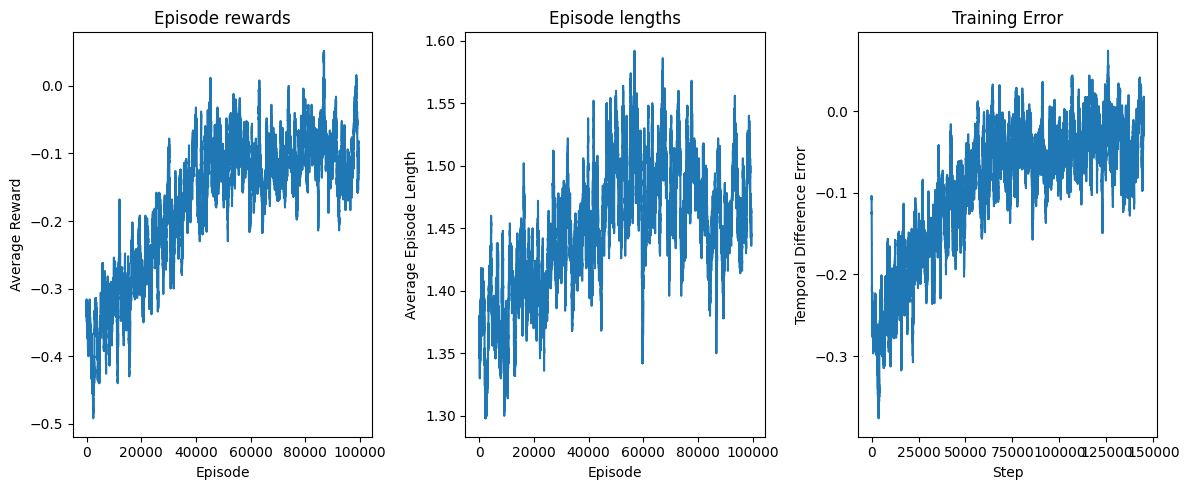

In [16]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()